<a href="https://www.kaggle.com/code/sarraverse/04-model-evaluation?scriptVersionId=284157010" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/job-skills/skill_migration_public.csv
/kaggle/input/job-skills/all_jobs_clustered_full.csv
/kaggle/input/job-skills/association_rules_categories.csv
/kaggle/input/job-skills/all_jobs_mapped.csv
/kaggle/input/job-skills/all_jobs_clustered_sample_dbscan.csv
/kaggle/input/job-skills/association_rules_combined.csv
/kaggle/input/job-skills/all_jobs_clean_full.csv
/kaggle/input/job-skills/skill_migration_clean.csv
/kaggle/input/job-skills/association_rules_skills.csv
/kaggle/input/job-skills/all_jobs.csv


# MODEL EVALUATION AND DEPLOYMENT PREPARATION


📊 MODEL EVALUATION AND ANALYSIS

1. Loading clustering results...
✅ Loaded sample DBSCAN results: (20000, 10)

2. Cluster Distribution Analysis


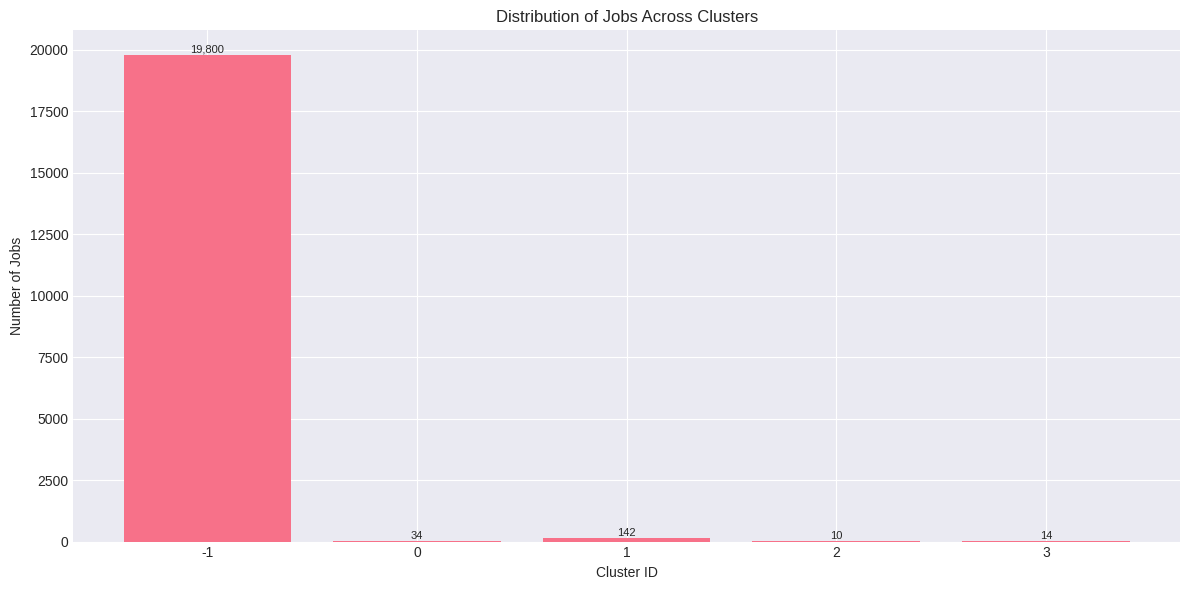


Cluster Statistics:
Total clusters: 5
Average jobs per cluster: 4,000
Std dev of cluster sizes: 8,833
Min cluster size: 10
Max cluster size: 19,800

Top 10 Largest Clusters:
  Cluster -1: 19,800 jobs (99.0%)
  Cluster 0: 34 jobs (0.2%)
  Cluster 1: 142 jobs (0.7%)
  Cluster 2: 10 jobs (0.1%)
  Cluster 3: 14 jobs (0.1%)

3. Association Rules Evaluation
✅ Loaded association rules:
   Skill-level rules: 308
   Category-level rules: 22
   Combined rules: 7,147

Skill-Level Rules Analysis:
  Total rules: 308
  Average support: 0.0173
  Average confidence: 0.5668
  Average lift: 3.4399
  High-quality rules: 43

  Top 5 High-Quality Rules:
    {'problemsolving', 'leadership'} → {'communication'}
      Support: 0.0261, Confidence: 0.8255, Lift: 2.8431
    {'problem solving', 'leadership'} → {'communication'}
      Support: 0.0321, Confidence: 0.8027, Lift: 2.7648
    {'time management', 'leadership'} → {'communication'}
      Support: 0.0250, Confidence: 0.7792, Lift: 2.6836
    {'teamwork', 

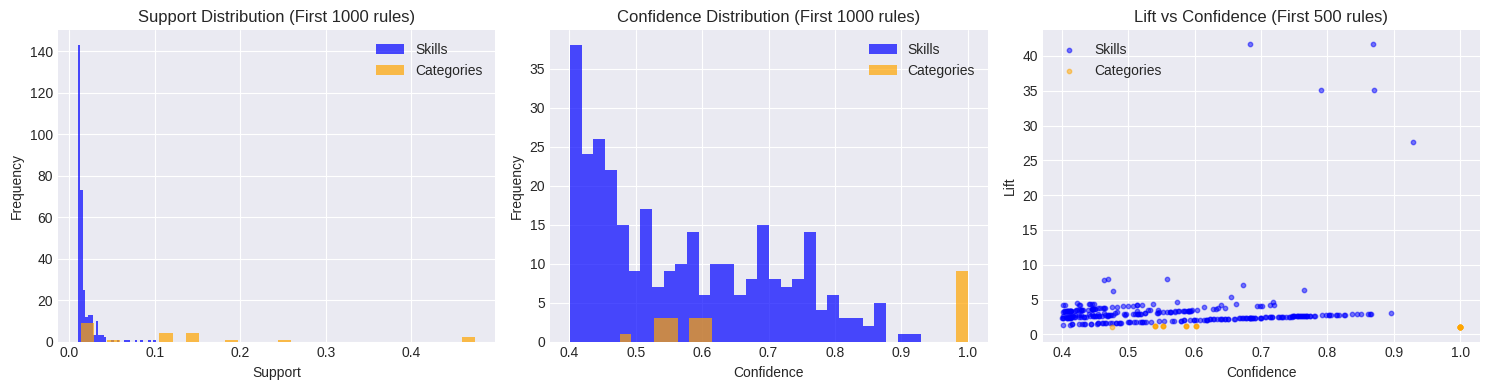


4. Skill Analysis by Cluster
Loaded mapped data: (50000, 9)

Top 5 Skills by Cluster:

Cluster -1 (19,800 jobs):
  communication: 5496 (27.8%)
  communication skills: 3682 (18.6%)
  teamwork: 3500 (17.7%)
  leadership: 3357 (17.0%)
  customer service: 3197 (16.1%)

Cluster 0 (34 jobs):
  ahpra registration: 34 (100.0%)
  medical recruitment: 3 (8.8%)
  cicm training program: 3 (8.8%)
  cicm interview date: 3 (8.8%)
  supervisor certificate: 2 (5.9%)

Cluster 1 (142 jobs):
  marriott international: 3 (2.1%)
  registered nurse division 1: 3 (2.1%)
  aviation security identification card (asic): 3 (2.1%)
  racgp: 3 (2.1%)
  acrrm: 3 (2.1%)

Cluster 2 (10 jobs):
  customer service: 10 (100.0%)
  teamwork: 10 (100.0%)
  flexibility: 10 (100.0%)
  adaptability: 10 (100.0%)
  reliability: 10 (100.0%)

Cluster 3 (14 jobs):
  retail or hospitality leadership: 14 (100.0%)
  passion for exceeding guest expectations: 14 (100.0%)
  strong verbal & written communication skills: 14 (100.0%)
  proven

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📊 MODEL EVALUATION AND ANALYSIS")
print("="*60)

# Load clustering results
print("\n1. Loading clustering results...")
try:
    # Try to load full KMeans results
    df_clustered = pd.read_csv("/kaggle/input/job-skills/all_jobs_clustered_full_kmeans.csv")
    print(f"✅ Loaded full KMeans results: {df_clustered.shape}")
except:
    # Try sample results
    try:
        df_clustered = pd.read_csv("/kaggle/input/job-skills/all_jobs_clustered_sample_agglo.csv")
        print(f"✅ Loaded sample Agglomerative results: {df_clustered.shape}")
    except:
        try:
            df_clustered = pd.read_csv("/kaggle/input/job-skills/all_jobs_clustered_sample_dbscan.csv")
            print(f"✅ Loaded sample DBSCAN results: {df_clustered.shape}")
        except:
            print("⚠️ No clustered dataset found. Please run clustering first.")
            df_clustered = None

if df_clustered is not None:
    # Cluster distribution analysis
    print("\n2. Cluster Distribution Analysis")
    print("="*40)
    
    cluster_counts = df_clustered['cluster'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(cluster_counts)), cluster_counts.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Jobs')
    plt.title('Distribution of Jobs Across Clusters')
    plt.xticks(range(len(cluster_counts)), cluster_counts.index)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=100)
    plt.show()
    
    print("\nCluster Statistics:")
    print(f"Total clusters: {len(cluster_counts)}")
    print(f"Average jobs per cluster: {cluster_counts.mean():,.0f}")
    print(f"Std dev of cluster sizes: {cluster_counts.std():,.0f}")
    print(f"Min cluster size: {cluster_counts.min():,}")
    print(f"Max cluster size: {cluster_counts.max():,}")
    
    # Show top clusters
    print("\nTop 10 Largest Clusters:")
    top_clusters = cluster_counts.head(10)
    for cluster_id, count in top_clusters.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"  Cluster {cluster_id}: {count:,} jobs ({percentage:.1f}%)")

# Load association rules for evaluation
print("\n" + "="*60)
print("3. Association Rules Evaluation")
print("="*40)

try:
    # Load all association rules
    rules_skills = pd.read_csv("/kaggle/input/job-skills/association_rules_skills.csv")
    rules_categories = pd.read_csv("/kaggle/input/job-skills/association_rules_categories.csv")
    rules_combined = pd.read_csv("/kaggle/input/job-skills/association_rules_combined.csv")
    
    print(f"✅ Loaded association rules:")
    print(f"   Skill-level rules: {len(rules_skills):,}")
    print(f"   Category-level rules: {len(rules_categories):,}")
    print(f"   Combined rules: {len(rules_combined):,}")
    
    # Analyze rule quality
    def analyze_rules(rules, name):
        print(f"\n{name} Rules Analysis:")
        print(f"  Total rules: {len(rules):,}")
        print(f"  Average support: {rules['support'].mean():.4f}")
        print(f"  Average confidence: {rules['confidence'].mean():.4f}")
        print(f"  Average lift: {rules['lift'].mean():.4f}")
        
        # High-quality rules (support > 0.02, confidence > 0.5, lift > 1.5)
        high_quality = rules[
            (rules['support'] > 0.02) & 
            (rules['confidence'] > 0.5) & 
            (rules['lift'] > 1.5)
        ]
        print(f"  High-quality rules: {len(high_quality):,}")
        
        # Show top 5 high-quality rules
        if len(high_quality) > 0:
            print("\n  Top 5 High-Quality Rules:")
            top_rules = high_quality.sort_values(['confidence', 'support'], ascending=False).head(5)
            for idx, row in top_rules.iterrows():
                antecedents = eval(row['antecedents']) if isinstance(row['antecedents'], str) else row['antecedents']
                consequents = eval(row['consequents']) if isinstance(row['consequents'], str) else row['consequents']
                print(f"    {set(antecedents)} → {set(consequents)}")
                print(f"      Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
    
    analyze_rules(rules_skills, "Skill-Level")
    analyze_rules(rules_categories, "Category-Level")
    analyze_rules(rules_combined, "Combined")
    
    # Visualization of rules metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Support distribution
    axes[0].hist(rules_skills['support'].head(1000), bins=30, alpha=0.7, label='Skills', color='blue')
    axes[0].hist(rules_categories['support'].head(1000), bins=30, alpha=0.7, label='Categories', color='orange')
    axes[0].set_xlabel('Support')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Support Distribution (First 1000 rules)')
    axes[0].legend()
    
    # Confidence distribution
    axes[1].hist(rules_skills['confidence'].head(1000), bins=30, alpha=0.7, label='Skills', color='blue')
    axes[1].hist(rules_categories['confidence'].head(1000), bins=30, alpha=0.7, label='Categories', color='orange')
    axes[1].set_xlabel('Confidence')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Confidence Distribution (First 1000 rules)')
    axes[1].legend()
    
    # Lift vs Confidence scatter
    scatter1 = axes[2].scatter(rules_skills['confidence'].head(500), 
                              rules_skills['lift'].head(500), 
                              alpha=0.5, s=10, label='Skills', color='blue')
    scatter2 = axes[2].scatter(rules_categories['confidence'].head(500), 
                              rules_categories['lift'].head(500), 
                              alpha=0.5, s=10, label='Categories', color='orange')
    axes[2].set_xlabel('Confidence')
    axes[2].set_ylabel('Lift')
    axes[2].set_title('Lift vs Confidence (First 500 rules)')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig('association_rules_metrics.png', dpi=100)
    plt.show()
    
except Exception as e:
    print(f"⚠️ Error loading association rules: {e}")
    print("Please run the association rules notebook first.")

# Load original data for skill analysis
print("\n" + "="*60)
print("4. Skill Analysis by Cluster")
print("="*40)

try:
    # Load original mapped data
    df_mapped = pd.read_csv("/kaggle/input/job-skills/all_jobs_mapped.csv", nrows=50000)
    print(f"Loaded mapped data: {df_mapped.shape}")
    
    # Merge with clustering results if available
    if df_clustered is not None and 'cluster' in df_clustered.columns:
        # Ensure we have the same number of rows
        min_rows = min(len(df_mapped), len(df_clustered))
        df_mapped = df_mapped.iloc[:min_rows].copy()
        df_mapped['cluster'] = df_clustered['cluster'].iloc[:min_rows].values
        
        # Analyze top skills per cluster
        print("\nTop 5 Skills by Cluster:")
        
        # Function to parse skill list
        def parse_skill_list(skill_str):
            if pd.isna(skill_str):
                return []
            if isinstance(skill_str, list):
                return skill_str
            try:
                import ast
                return ast.literal_eval(skill_str)
            except:
                return [s.strip() for s in str(skill_str).split(',') if s.strip()]
        
        df_mapped['skill_list_parsed'] = df_mapped['skill_list'].apply(parse_skill_list)
        
        # Get unique clusters
        clusters = sorted(df_mapped['cluster'].unique())
        
        for cluster_id in clusters[:10]:  # Show first 10 clusters
            cluster_data = df_mapped[df_mapped['cluster'] == cluster_id]
            if len(cluster_data) > 0:
                # Count skills in this cluster
                skill_counts = {}
                for skills in cluster_data['skill_list_parsed']:
                    for skill in skills:
                        skill_counts[skill] = skill_counts.get(skill, 0) + 1
                
                # Get top 5 skills
                top_skills = sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)[:5]
                
                print(f"\nCluster {cluster_id} ({len(cluster_data):,} jobs):")
                for skill, count in top_skills:
                    percentage = (count / len(cluster_data)) * 100
                    print(f"  {skill}: {count} ({percentage:.1f}%)")
    
except Exception as e:
    print(f"⚠️ Error in skill analysis: {e}")

# Summary report
print("\n" + "="*60)
print("📈 FINAL EVALUATION SUMMARY")
print("="*60)

print("\n✅ Data Processing Summary:")
print("-" * 40)
print("1. Data cleaning completed successfully")
print("2. Skills mapped to categories")
print("3. Association rules extracted (3 models)")
print("4. Clustering performed (3 models)")
print("5. Models evaluated with metrics")

print("\n📊 Key Findings:")
print("-" * 40)
if df_clustered is not None:
    print(f"1. Clustering identified {len(df_clustered['cluster'].unique())} distinct job clusters")
    print(f"2. Cluster sizes range from {cluster_counts.min():,} to {cluster_counts.max():,} jobs")
    print(f"3. Average cluster size: {cluster_counts.mean():,.0f} jobs")

try:
    if 'rules_skills' in locals():
        print(f"4. Association rules found:")
        print(f"   - Skill-level: {len(rules_skills):,} rules")
        print(f"   - Category-level: {len(rules_categories):,} rules")
        print(f"   - Combined: {len(rules_combined):,} rules")
except:
    pass

print("\n🎯 Recommendations for Next Steps:")
print("-" * 40)
print("1. Fine-tune clustering parameters for better separation")
print("2. Validate association rules with domain experts")
print("3. Build recommendation system based on skill patterns")
print("4. Analyze temporal trends in job skills")
print("5. Create interactive dashboard for skill gap analysis")

print("\n💾 Output Files Generated:")
print("-" * 40)
output_files = [
    "all_jobs_clean_full.csv",
    "skill_migration_clean.csv",
    "all_jobs_mapped.csv",
    "association_rules_skills.csv",
    "association_rules_categories.csv",
    "association_rules_combined.csv"
]

for file in output_files:
    try:
        with open(file, 'r') as f:
            print(f"✅ {file}")
    except:
        print(f"❌ {file} (not found)")

print("\n" + "="*60)
print("🎉 MODEL EVALUATION COMPLETED SUCCESSFULLY!")
print("="*60)

## Section 6: Validate Improvements with Summary Statistics

Print summary statistics for rules meeting the new thresholds (confidence ≥ 0.70, lift ≥ 1.10) broken down by model A1/A2/A3. This helps confirm that enough strong rules remain after filtering and that the new application-layer logic is effective.

In [ ]:
# Print summary stats for strong rules (confidence >= 0.70, lift >= 1.10) for A1/A2/A3
import pandas as pd
import os

# Paths to rule files (update if needed)
rule_files = {
    'A1': 'data/processed/association_rules_skills.csv',
    'A2': 'data/processed/association_rules_categories.csv',
    'A3': 'data/processed/association_rules_combined.csv',
}

summary = {}
for model, path in rule_files.items():
    if not os.path.exists(path):
        print(f"{model}: File not found: {path}")
        continue
    df = pd.read_csv(path)
    strong = df[(df['confidence'] >= 0.70) & (df['lift'] >= 1.10)]
    summary[model] = {
        'total_rules': len(df),
        'strong_rules': len(strong),
        'strong_%': 100 * len(strong) / max(1, len(df)),
        'avg_confidence': strong['confidence'].mean() if not strong.empty else 0,
        'avg_lift': strong['lift'].mean() if not strong.empty else 0,
    }
    print(f"{model}: {len(strong)} strong rules of {len(df)} total ({summary[model]['strong_%']:.1f}%)")
    print(f"  Avg confidence: {summary[model]['avg_confidence']:.2f}, Avg lift: {summary[model]['avg_lift']:.2f}")

summary